In [21]:
def read_fasta(file_path):
    """
    Reads a FASTA file and returns a dictionary where keys are the headers (chromosomes)
    and values are the corresponding sequences.
    """
    with open(file_path, 'r') as file:
        sequences = {}
        header = None # Initiating header to None
        sequence = []

        for line in file:
            line = line.strip()
            if line.startswith(">"):
                if header:
                    sequences[header] = ''.join(sequence)
                header = line[1:]  # Remove '>' character
                sequence = []
            else:
                sequence.append(line.upper())
        
        # Add the last sequence
        if header:
            sequences[header] = ''.join(sequence)

    return sequences

In [22]:
def restriction_sites(file_path):
    """
    Reads the enzyme file and returns a dictionary where keys are the enzymes and values are a list
    consisting cutsite and the nick.
    """
    enzymes = read_fasta(file_path)
    for key in enzymes:
        nick = enzymes[key].find("/")
        enzymes[key] = [enzymes[key].replace("/", "").replace("N", "[ACTG]").replace("Y", "[CT]").replace("R", "[AG]").replace("W","[AT]"), nick]
        # Replace all the placeholders with the corresponding regex
    return enzymes

In [23]:
def find_restriction_sites(genome, enzyme):
    """
    Finds restriction sites in the genome. Returns a dictionary where keys are headers (chromosomes)
    and values are lists of positions of the restriction site.
    """
    import re
    
    positions = {}
    restriction_site = restriction_sites("test_enzyme.fa")[enzyme]

    for chr, seq in genome.items():
        positions[chr] = [0]+ [restriction_site[1] + m.start() for m in re.finditer(restriction_site[0], seq)]
        # Find all the restriction sites and add the nick to the position, add the first position of the chromosome
        if positions[chr][-1] != len(seq):
            positions[chr].append(len(seq))
        # Add the last position of the chromosome

    return positions


In [24]:
def genome_methylation(genome, enzyme):
    """
    Assuing the input to be a genome dictionary returned by read_fasta function and an methylase name,
    returns a genome dictionary where all the methylated sites are replaced by "E"
    """
    import re

    methylated_genome = {}
    methyl_site = restriction_sites("test_enzyme.fa")[enzyme][0]
    methyl_pos = restriction_sites("test_enzyme.fa")[enzyme][1]

    # Find all the methylation sites and replace the methylated nucleotides inside the methylation sites with capital "E"
    for chr, seq in genome.items():
        for m in re.finditer(methyl_site, seq):
            seq = seq[:m.start()+methyl_pos] + "E" + seq[m.start()+methyl_pos+1:]
        methylated_genome[chr] = seq
    
    return methylated_genome

genome_methylation({"ChrI": "CACACGGTG", "ChrII": "AAAAAAAGATCCTGGC"}, "Dcm")

{'ChrI': 'CACACGGTG', 'ChrII': 'AAAAAAAGATCETGGC'}

In [27]:
def random_fragment(sites, min_size, max_size):
    """
    Input is a list of restriction sites, and the maximum and minimum size of the fragment,
    output is a list of restriction sites inserted with random break sites.
    """
    from numpy import random

    new_sites = sites.copy()  # Copy the original list to avoid modifying it
    current_position = sites[0]
    normal_distribution = random.normal(
        loc=(max_size+min_size)/2,
        size=100000
    )

    while current_position < sites[-1]:
        current_position += round((normal_distribution[random.randint(0, 100000)]))
        if current_position < sites[-1]:
            new_sites.append(current_position)

    return sorted(new_sites)

/tmp/ipykernel_101128/1489700999.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(pd.cut(df.index, bins=bins)).sum()


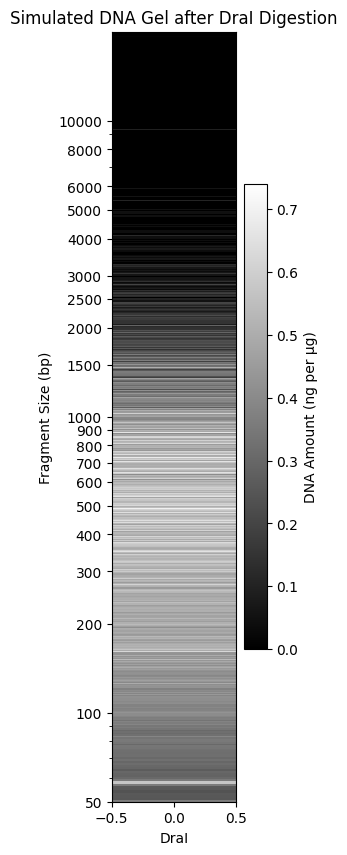

/tmp/ipykernel_101128/1489700999.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_new = df.groupby(pd.cut(df.index, bins=bins_new)).sum()
/tmp/ipykernel_101128/1489700999.py:101: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, df_new.index[-1])


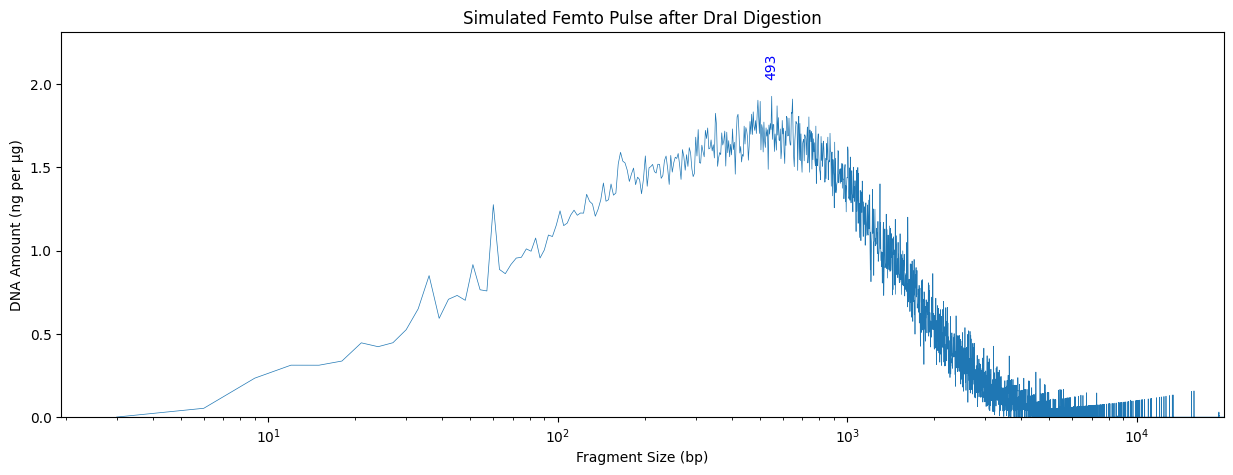

In [28]:
def main():
    import matplotlib.pyplot as plt
    from collections import Counter
    import pandas as pd

    genome_file = "../genome_celegans.fa"
    enzyme_file = "test_enzyme.fa"

    # Read genome and restriction enzyme sites
    genome = read_fasta(genome_file)
    enzymes = restriction_sites(enzyme_file)
    
    # Create a dictionary to store the restriction sites for the selected enzymes
    #selected_enzymes = [enzyme.strip() for enzyme in input("Enter the names of the enzymes separated by commas (e.g., EcoRI, HindIII): ").split(',')]
    #selected_enzymes = "EcoRI, HindIII".split(',')
    selected_enzymes = "DraI".split(',')
    # Find restriction s]ites for the selected enzymes and generate the selected_restriction_sites dictionary
    
    from collections import defaultdict
    selected_restriction_sites = defaultdict(set) # Use defaultdict to avoid key errors and store unique restriction sites
    for enzyme_name in selected_enzymes:
        enzyme_name = enzyme_name.strip() # Remove whitespaces
        if enzyme_name in enzymes:
            enzyme_sites = find_restriction_sites(genome, enzyme_name)
            for chr, sites in enzyme_sites.items(): # Add the restriction sites to the selected_restriction_sites dictionary
                selected_restriction_sites[chr].update(sites)
        else:
            print("{enzyme} not found!".format(enzyme=enzyme_name))
    
    for chr in selected_restriction_sites: # Sort the restriction sites and convert the set to sorted list
        selected_restriction_sites[chr] = sorted(list(selected_restriction_sites[chr]))
    
    # Simulate the fragmentation during genome DNA extraction
    distances = []
    for chr, sites in selected_restriction_sites.items():
        for i in range(100):
            sites_with_fragmentation = random_fragment(sites, 35000, 100000)
            distances_in_chr = [sites_with_fragmentation[i+1] - sites_with_fragmentation[i] for i in range(len(sites_with_fragmentation)-1)]
            distances.extend(distances_in_chr)


    # Summarize the fragment sizes by printing the sum of the fragment sizes in each bin
    bins = [i for i in range(0, 20000, 1)]
    
    # Make a pandas dataframe to store the fragment sizes and their counts. Using bins of size 1
    distances_count = Counter(distances)

    # Sum the counts of the fragment sizes in each bin
    df = pd.DataFrame.from_dict(distances_count, orient='index').reset_index()
    df.columns = ['size', 'count']

    # df.to_csv("fragment_sizes.csv", index=False)
    df["bases"] = df["size"] * df["count"]
    
    # Create an index column with the fragment sizes
    df.set_index("size", inplace=True)
    
    # Delete the count column
    del df["count"]
    
    # Convert the df index into bins
    df = df.groupby(pd.cut(df.index, bins=bins)).sum()

    # Change the index into an integer by converting the string into a list and taking the first element
    df.index = [int(str(i)[1:-1].split(",")[1]) for i in df.index]

    # Normalize the bases column
    df["bases"] = df["bases"] / df["bases"].sum() * 1000

    # Plot the simulated gel electrophoresis
    plt.figure(figsize=(2, 10))
    plt.imshow(df, aspect='auto', cmap="gray")
    plt.yscale('log')
    plt.ylim(50, df.index[-1])

    # set yticks from a list
    ticks = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 8000, 10000]
    plt.yticks(ticks, ticks)


    plt.colorbar(label='DNA Amount (ng per µg)')
    xlabel = " + ".join(selected_enzymes)
    plt.xlabel(xlabel)
    plt.ylabel('Fragment Size (bp)')
    plt.title("Simulated DNA Gel after " + " +".join(selected_enzymes) + " Digestion")
    #plt.savefig(" +".join(selected_enzymes) + " Gel.jpg", dpi=1000, bbox_inches='tight')
    plt.show()

    # Make another plot based on df, with index as x and bases as y
    import seaborn as sns

    bins_new = [i for i in range(0, 20000, 3)]
    df_new = df.groupby(pd.cut(df.index, bins=bins_new)).sum()
    df_new["bases"] = df_new["bases"]/df_new["bases"].sum() * 1000
    df_new.index = [int(str(i)[1:-1].split(",")[1]) for i in df_new.index]

    plt.figure(figsize=(15, 5))
    sns.lineplot(x=df_new.index, y=df_new["bases"], linewidth=0.5)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(0, df_new.index[-1])
    plt.ylim(0, df_new["bases"].max()*1.2)
    plt.xlabel("Fragment Size (bp)")
    plt.ylabel("DNA Amount (ng per µg)")
    plt.title("Simulated Femto Pulse after " + " +".join(selected_enzymes) + " Digestion")
    # Annotate the data point with the highest DNA amount
    plt.annotate(str(round(df["bases"].idxmax())), xy=(df["bases"].idxmax(), df["bases"].max()), xytext=(df_new["bases"].idxmax(), df_new["bases"].max()*1.05),
                 rotation=90, ha='center', va='bottom', color="blue")
    #plt.savefig("celegans_femtopulse_" + " +".join(selected_enzymes) + ".jpg", dpi=1000)
    plt.show()

    return distances # Return the distances list to be used in the plot

    
if __name__ == "__main__":
    main()

In [ ]:
def enzyme_iteration(genome_file, enzyme_file):
    from collections import defaultdict
    from collections import Counter
    enzymes = restriction_sites(enzyme_file)
    genome = read_fasta(genome_file)
    iteration_result = {}

    for enzyme in enzymes:
        selected_restriction_sites = defaultdict(set) # Use defaultdict to avoid key errors and store unique restriction sites
        enzyme_sites = find_restriction_sites(genome, enzyme)
        for chr, sites in enzyme_sites.items():
            selected_restriction_sites[chr].update(sites)
        for chr in selected_restriction_sites:
            selected_restriction_sites[chr] = sorted(list(selected_restriction_sites[chr]))

        distances = []
        for chr, sites in selected_restriction_sites.items():
            for i in range(500):
                sites_with_fragmentation = random_fragment(sites, 35000, 100000)
                distances_in_chr = [sites_with_fragmentation[i+1] - sites_with_fragmentation[i] for i in range(len(sites_with_fragmentation)-1)]
                distances.extend(distances_in_chr)
        
        distances_count = Counter(distances)
        for size, count in distances_count.items():
            distances_count[size] = size * count
        max_proportion = max(distances_count.values())
        for size, propor in distances_count.items():
            if propor == max_proportion:
                iteration_result[enzyme] = size
    
    return iteration_result

enzyme_iteration("../genome_celegans.fa", "test_enzyme.fa")